In [3]:
import random
import timeit
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3

def generate_test_case(num_vars, num_clauses, clause_length):
    test_case = []
    for _ in range(num_clauses):
        clause = set()
        while len(clause) < clause_length:
            var = random.randint(1, num_vars)
            negated = random.choice([True, False])
            clause.add(-var if negated else var)
        test_case.append(list(clause))
    return test_case

# It first extracts all variables present in the formula and sorts them in ascending order.
# It then iterates over all possible assignments of truth values to the variables (2^n possible assignments for n variables).
# For each assignment, it checks if the formula is satisfied by evaluating each clause in the formula using the given assignment. If all clauses are satisfied, it returns True along with the satisfying assignment.
# If no satisfying assignment is found after trying all possible assignments, it returns False along with an empty assignment dictionary.
def naive(formula):
    # Get the list of variables in the formula
    variables = set()
    for clause in formula:
        for variable in clause:
            variables.add(abs(variable))
    variables = sorted(list(variables))

    # Try all possible assignments of truth values to the variables
    num_variables = len(variables)
    for i in range(2 ** num_variables):
        assignment = {}
        for j in range(num_variables):
            variable = variables[j]
            # If the negation of the variable is not present in the formula, then the truth value of its negation is also added to the assignment dictionary.
            assignment[variable] = (i >> j) & 1 == 1
            if variable * -1 not in variables:
                assignment[-variable] = not assignment[variable]

        # Check if the assignment satisfies the formula
        satisfied = True
        for clause in formula:
            clause_satisfied = False
            for variable in clause:
                if (variable > 0 and assignment[variable]) or (variable < 0 and not assignment[-variable]):
                    clause_satisfied = True
                    break
            if not clause_satisfied:
                satisfied = False
                break

        if satisfied:
            return True, assignment

    # No satisfying assignment found
    return False, {}

# If the formula is empty, it is trivially satisfiable, and the current assignment is returned.
# If any clause in the formula is empty, the formula is unsatisfiable, and the current assignment is returned.
# If there exists a unit clause (a clause with only one literal), the literal in that clause must be assigned a truth value. The clause containing that literal and any other clauses containing the negation of that literal are removed from the formula. The DPLL algorithm is then called recursively on the simplified formula with the new assignment.
# If there is no unit clause, a variable is selected (the first literal of the first clause is arbitrarily chosen in this implementation), and the DPLL algorithm is called recursively twice: once with the variable assigned True, and once with the variable assigned False. If either recursive call returns a satisfiable assignment, that assignment is returned.
# If no satisfying assignment is found, the function returns False along with the current assignment.

def dpll(formula, assignment):
    if not formula:
        return True, assignment
    
    if any(not clause for clause in formula):
        return False, assignment
    
    unit_clauses = [c for c in formula if len(c) == 1]
    if unit_clauses:
        unit = unit_clauses[0][0]
        new_formula = [[l for l in c if l != -unit] for c in formula if unit not in c]
        return dpll(new_formula, assignment + [unit])
    
    variable = abs(formula[0][0])
    
    for value in [variable, -variable]:
        new_formula = [[l for l in c if l != -value] for c in formula if value not in c]
        result, new_assignment = dpll(new_formula, assignment + [value])
        if result:
            return result, new_assignment

    return False, assignment

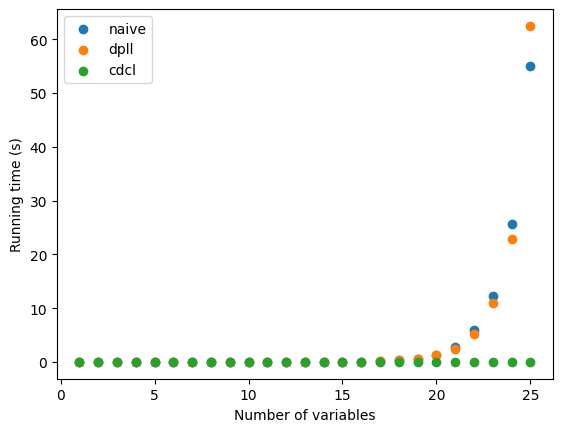

In [7]:
data = []
solver = Glucose3()
for i in range(25, 26):
    num_vars = i
    num_clauses = 2**i
    clause_length = i
    test_case = generate_test_case(num_vars, num_clauses, clause_length)
    
    for clause in test_case:
        solver.add_clause(clause)


    # naive_time = timeit.timeit(lambda: naive(test_case), number=1)
    # dpll_time = timeit.timeit(lambda: dpll(test_case, []), number=1)
    cdcl_time = timeit.timeit(lambda: solver.solve, number=1)
        
    data.append((num_vars, num_clauses, clause_length, cdcl_time))

# plt.scatter([d[0] for d in data], [d[3] for d in data], label='naive')
# plt.scatter([d[0] for d in data], [d[4] for d in data], label='dpll')
plt.scatter([d[0] for d in data], [d[3] for d in data], label='cdcl')
plt.xlabel('Number of variables')
plt.ylabel('Running time (s)')
plt.legend()
plt.show()
solver.delete()